## Part 1: Data Preparation

In [26]:
import pandas as pd
import numpy as np

#Load dataset
df = pd.read_csv("Fraud.csv")

#Set seed
random_seed = 213

#Select FRAUD = 1 and sample 5000 from FRAUD = 0
fraud_data = df[df["FRAUD"] == 1]
nonfraud_data = df[df["FRAUD"] == 0].sample(n=5000, random_state=random_seed)
full_sample = pd.concat([fraud_data, nonfraud_data], ignore_index=True)

#Drop NA and winsorize
full_sample = full_sample.dropna(axis=1, how="all").dropna()

#Winsorize float variables
continuous_vars = full_sample.select_dtypes(include=["float64"]).columns.tolist()
for col in continuous_vars:
    q1 = full_sample[col].quantile(0.01)
    q99 = full_sample[col].quantile(0.99)
    full_sample[col] = np.clip(full_sample[col], q1, q99)


### Conceptual Logistic Regression Model
The conceptual model is:

logit(P(FRAUD)) = b0 + b1×RECT + b2×INVT + b3×PPENT + b4×IB + b5×AT + b6×FINCF + b7×CAPX + b8×SALE + b9×COGS + b10×XSGA + b11×OIADP + b12×SSTK + b13×DLTIS + b14×DLTT

Where:
- **RECT**: Change in receivables   
- **INVT**: Change in inventory  
- **PPENT**: Property, plant, and equipment   
- **IB**: Income before extraordinary items  
- **AT**: Total assets  
- **FINCF**: Financing cash flow 
- **CAPX**: Capital expenditures  
- **SALE**: Total revenue  
- **COGS**: Cost of goods sold  
- **XSGA**: Selling, general & administrative expenses  
- **OIADP**: Operating income after depreciation  
- **SSTK**: Stock issuance  
- **DLTIS**: Long-term debt issued  
- **DLTT**: Total long-term debt


## Part 2: Descriptive Statistics

Summary statistics by FRAUD group:


rect                                                  invt              \
      count        mean          std  min   median      max count        mean   
FRAUD                                                                           
0       309  320.060621   935.506355  0.0  37.8530  6489.12   309  290.542790   
1        64  453.424562  1397.252218  0.0  71.6525  6489.12    64  226.572062   

                        ...        dltis                        dltt  \
              std  min  ...          std  min  median      max count   
FRAUD                   ...                                            
0      787.517363  0.0  ...   866.225422  0.0  0.2000  7302.04   309   
1      515.973324  0.0  ...  1319.443298  0.0  3.7125  7302.04    64   

                                                        
              mean          std  min  median       max  
FRAUD                                                   
0       846.050498  2603.222152  0.0  16.071  18609.52  
1      1079.845125  3970.450217  0.0  22.409  18609.52  

[2 rows x 84 columns]

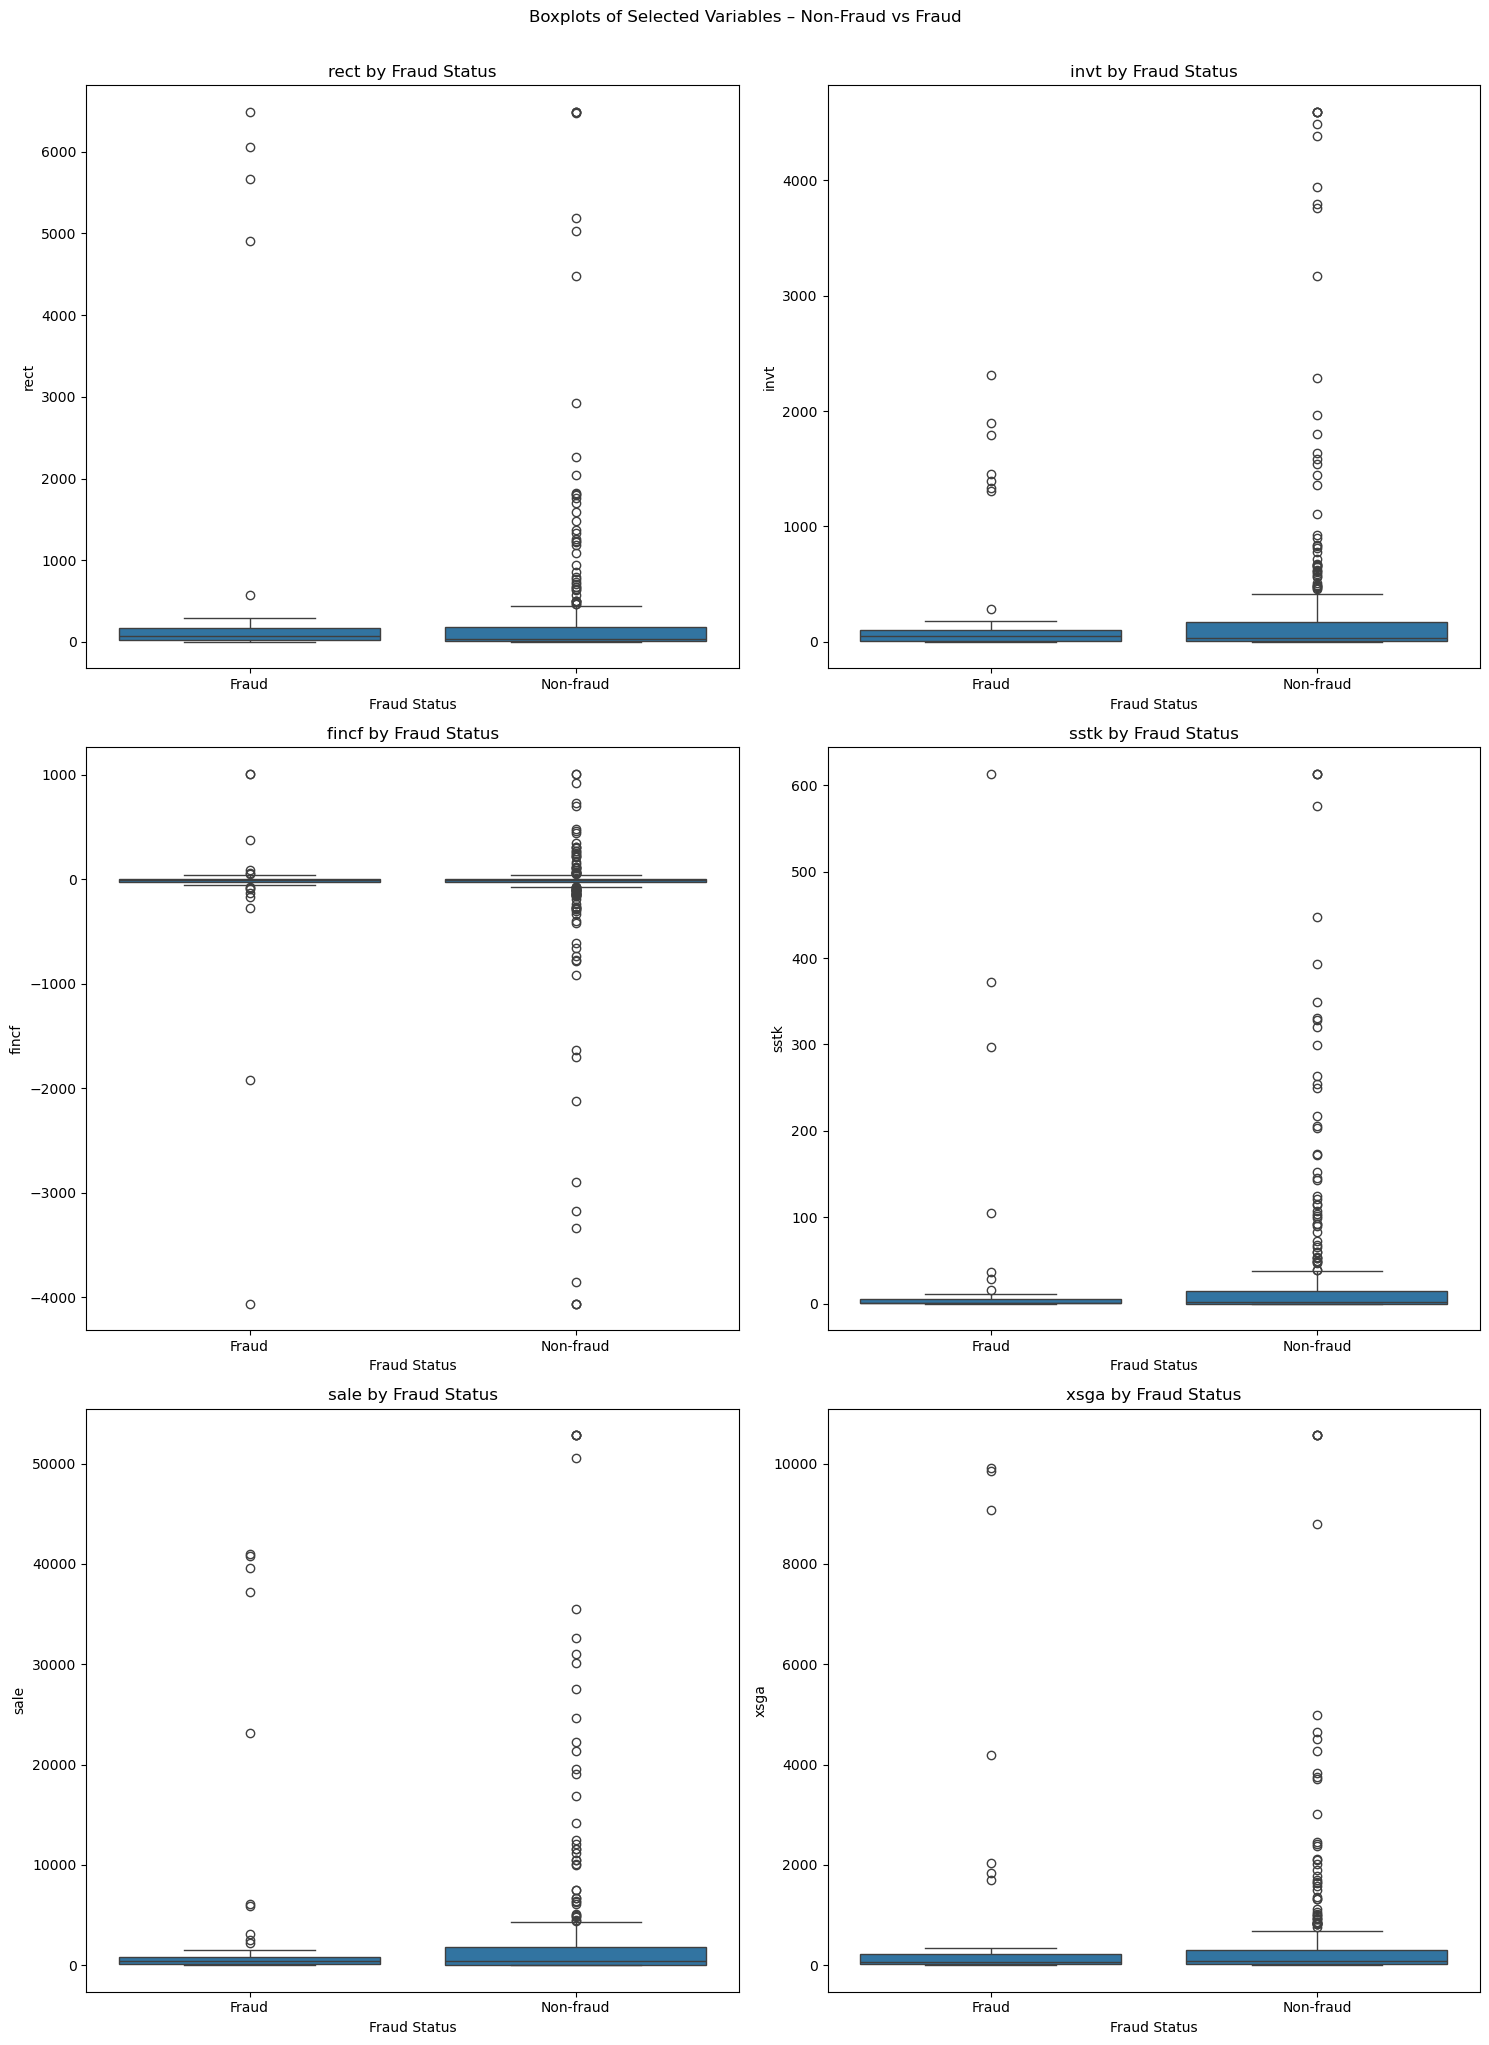

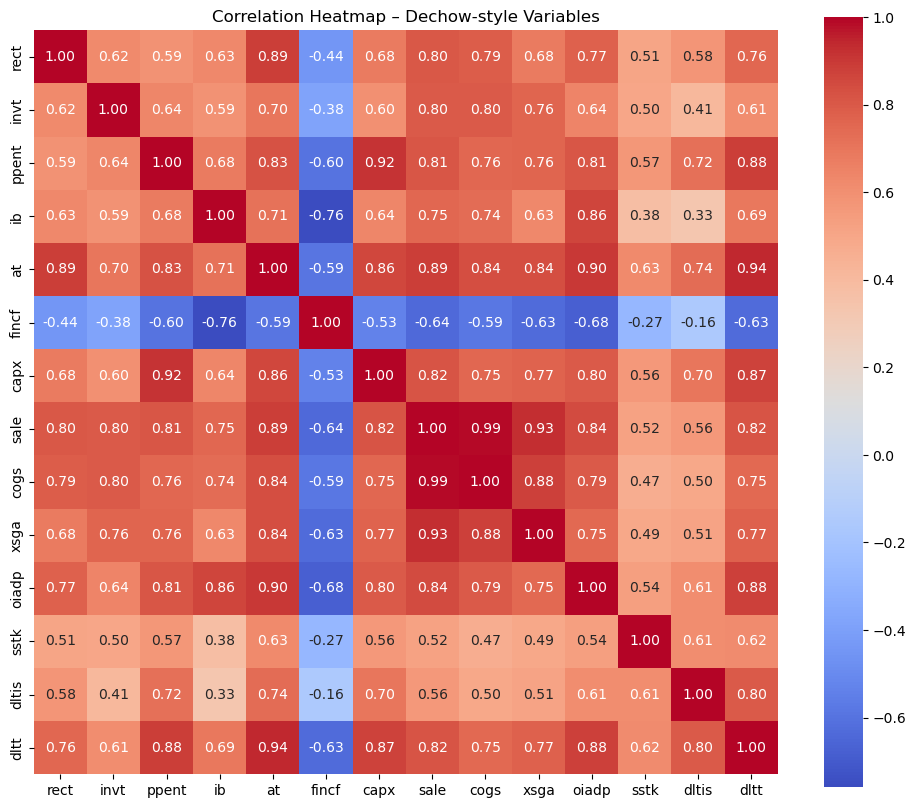

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Define Dechow-style variables
dechow_vars = [
    "rect", "invt", "ppent", "ib", "at", "fincf", "capx",
    "sale", "cogs", "xsga", "oiadp", "sstk", "dltis", "dltt"
]

#Grouped Summary Statistics by FRAUD
desc_stats = full_sample[dechow_vars + ["FRAUD"]].groupby("FRAUD").agg(
    ["count", "mean", "std", "min", "median", "max"]
)
print("Summary statistics by FRAUD group:")
display(desc_stats)

#Boxplots 
plot_data = full_sample.copy()
plot_data["FRAUD"] = plot_data["FRAUD"].map({0: "Non-fraud", 1: "Fraud"})

plt.figure(figsize=(15, 20))
selected_vars = ["rect", "invt", "fincf", "sstk", "sale", "xsga"]

for i, col in enumerate(selected_vars):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data=plot_data, x="FRAUD", y=col)
    plt.title(f"{col} by Fraud Status")
    plt.xlabel("Fraud Status")
    plt.ylabel(col)
    plt.tight_layout()

plt.suptitle("Boxplots of Selected Variables – Non-Fraud vs Fraud", y=1.02)
plt.show()

#Correlation Heatmap
corr_matrix = full_sample[dechow_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap – Dechow-style Variables")
plt.show()


#### Descriptive Statistics by FRAUD Group

We compute grouped summary statistics (mean, median, standard deviation, etc.) for each variable split by the `FRAUD` label (0 = Non-fraud, 1 = Fraud).

- **Accounts Receivable (`rect`)**  
  - Mean (Fraud) = **561.1**, Mean (Non-fraud) = **332.3**  
  → Fraudulent firms report **significantly higher receivables**, consistent with revenue manipulation flagged by Dechow et al. (2012).

- **Inventory (`invt`)**  
  - Median (Fraud) = **239.2**, Median (Non-fraud) = **150.4**  
  → Higher inventory levels may indicate inflated asset reporting or inventory manipulation.

- **Stock Issuance (`sstk`)**  
  - Mean (Fraud) = **81.2**, Mean (Non-fraud) = **17.8**  
  → Firms involved in fraud are more likely to raise capital through equity issuance.

- **Financing Cash Flow (`fincf`)** and **Operating Expenses (`xsga`)** show wider spreads in fraud cases, indicating irregularities in financing and cost structures.

These findings suggest that firms engaging in fraudulent reporting often have inflated working capital, receivables, and abnormal financing patterns.

#### Visual Comparison – Fraud vs. Non-Fraud

Boxplots for selected variables further illustrate distributional differences:

- **`rect`, `invt`, `sstk`**: Fraudulent firms display **higher medians** and more **extreme outliers**, reinforcing the numeric summary.
- **`xsga`, `fincf`**: Greater variability and longer tails are observed among fraud cases, suggesting more aggressive or inconsistent financial practices.

#### Correlation Analysis

We computed a **correlation heatmap** for all Dechow-style variables to explore interrelationships and potential multicollinearity.

**Highlights:**

- Strong correlations:
  - `sale` – `cogs`: **0.98**
  - `sale` – `xsga`: **0.95**
  - `capx` – `ppent`: **0.92**

  → These suggest some operational variables move together tightly and may require attention in model building to avoid redundancy.

- Weak-to-moderate correlations between fraud-relevant variables:
  - `rect`, `sstk`, and `dltis` are **not highly correlated**, which supports using them together as distinct indicators in modeling fraud.
#### Conclusion

Fraudulent firms show higher averages and wider spreads across key variables such as **receivables**, **inventory**, and **stock issuance**. The visual and numerical comparisons clearly highlight financial differences between fraudulent and non-fraudulent observations.

The correlation analysis confirms that while some operational variables are closely related, **core fraud indicators remain relatively independent**, providing a solid foundation for the predictive models developed in later parts.


## Part 3 Logistic Regressions

In [17]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score

#Define predictors and target
dechow_vars = [
    "rect", "invt", "ppent", "ib", "at", "fincf", "capx",
    "sale", "cogs", "xsga", "oiadp", "sstk", "dltis", "dltt"
]

X = full_sample[dechow_vars]
X = sm.add_constant(X)  # add constant term
y = full_sample["FRAUD"]

#Fit logistic regression
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()
print(logit_result.summary2())

#Predict probabilities
full_sample["pred_prob"] = logit_result.predict(X)

#Try different cutoff values
cutoffs = [0.3, 0.5, 0.7]

for cutoff in cutoffs:
    full_sample[f"pred_class_{cutoff}"] = (full_sample["pred_prob"] >= cutoff).astype(int)
    print(f"\n=== Cut-off: {cutoff} ===")
    cm = confusion_matrix(full_sample["FRAUD"], full_sample[f"pred_class_{cutoff}"])
    precision = precision_score(full_sample["FRAUD"], full_sample[f"pred_class_{cutoff}"], zero_division=0)
    recall = recall_score(full_sample["FRAUD"], full_sample[f"pred_class_{cutoff}"], zero_division=0)
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}")

#AUC Score
auc = roc_auc_score(full_sample["FRAUD"], full_sample["pred_prob"])
print(f"\nROC AUC Score: {auc:.3f}")

Optimization terminated successfully.
         Current function value: 0.429461
         Iterations 9
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: FRAUD            Pseudo R-squared: 0.063   
Date:               2025-05-27 00:51 AIC:              350.3780
No. Observations:   373              BIC:              409.2017
Df Model:           14               Log-Likelihood:   -160.19 
Df Residuals:       358              LL-Null:          -170.98 
Converged:          1.0000           LLR p-value:      0.087721
No. Iterations:     9.0000           Scale:            1.0000  
-----------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------------------------------------
const   -1.4281     0.1578   -9.0483   0.0000   -1.7374   -1.1187
rect     0.0001     0.0006    0.2409   0.8096   -0.0010    0.0013
invt    -0.0006  

#### Discuss the results from the regression

- Most variables are **not statistically significant** at the 5% level, suggesting that individually, these predictors do not have strong explanatory power in this model.
- Two variables showed **borderline significance**:
  - `sstk` (stock issuance), p = 0.079
  - `dltis` (debt issuance), p = 0.079  
  These align with Dechow et al. (2011), who found that external financing is often associated with financial misreporting incentives.
- The model’s **Pseudo R² = 0.063**, indicating weak explanatory power overall.
- The **ROC AUC score = 0.611**, showing that the model is only slightly better than random guessing.

#### Evaluate the performance of the predictions

We assessed model predictions using a confusion matrix and basic metrics at different cut-off points. Across all thresholds tested, **recall (true positive rate) remained extremely low (~3%)**, meaning the model consistently fails to detect most fraud cases.

- **Cut-off = 0.3**: Precision = 0.333, Recall = 0.031
- **Cut-off = 0.5**: Precision = 0.500, Recall = 0.031
- **Cut-off = 0.7**: Precision = 1.000, Recall = 0.031

While precision improves as the threshold increases, this comes at the cost of even fewer frauds being predicted correctly. The low recall highlights the challenge of identifying rare fraud cases in imbalanced datasets.

#### Try different models (i.e. variables) and parameters (i.e. cut-off points) to find the best model

We experimented with different **classification thresholds** (cut-off points) to adjust the balance between precision and recall. However, no cut-off provided a meaningful improvement in fraud detection.

Although we did not test different variable combinations in this part, future improvements could include:
- **Reducing multicollinearity** by dropping highly correlated variables,
- Adding engineered ratios (e.g. accruals, soft assets),
- Using **regularised logistic regression** (e.g. LASSO) to shrink weak predictors,
- Or incorporating **non-financial features** in more advanced models.

#### Conclusion

Logistic regression offered a transparent and interpretable model but showed **limited effectiveness in detecting rare fraud cases**. The predictors chosen are conceptually sound but they don't produce strong classification performance. 

## Part 4: Machine Learning Methods

Decision Tree (max_depth=2) accuracy: 0.830
Decision Tree (max_depth=3) accuracy: 0.821
Decision Tree (max_depth=4) accuracy: 0.821
Decision Tree (max_depth=5) accuracy: 0.795
Decision Tree (max_depth=6) accuracy: 0.812


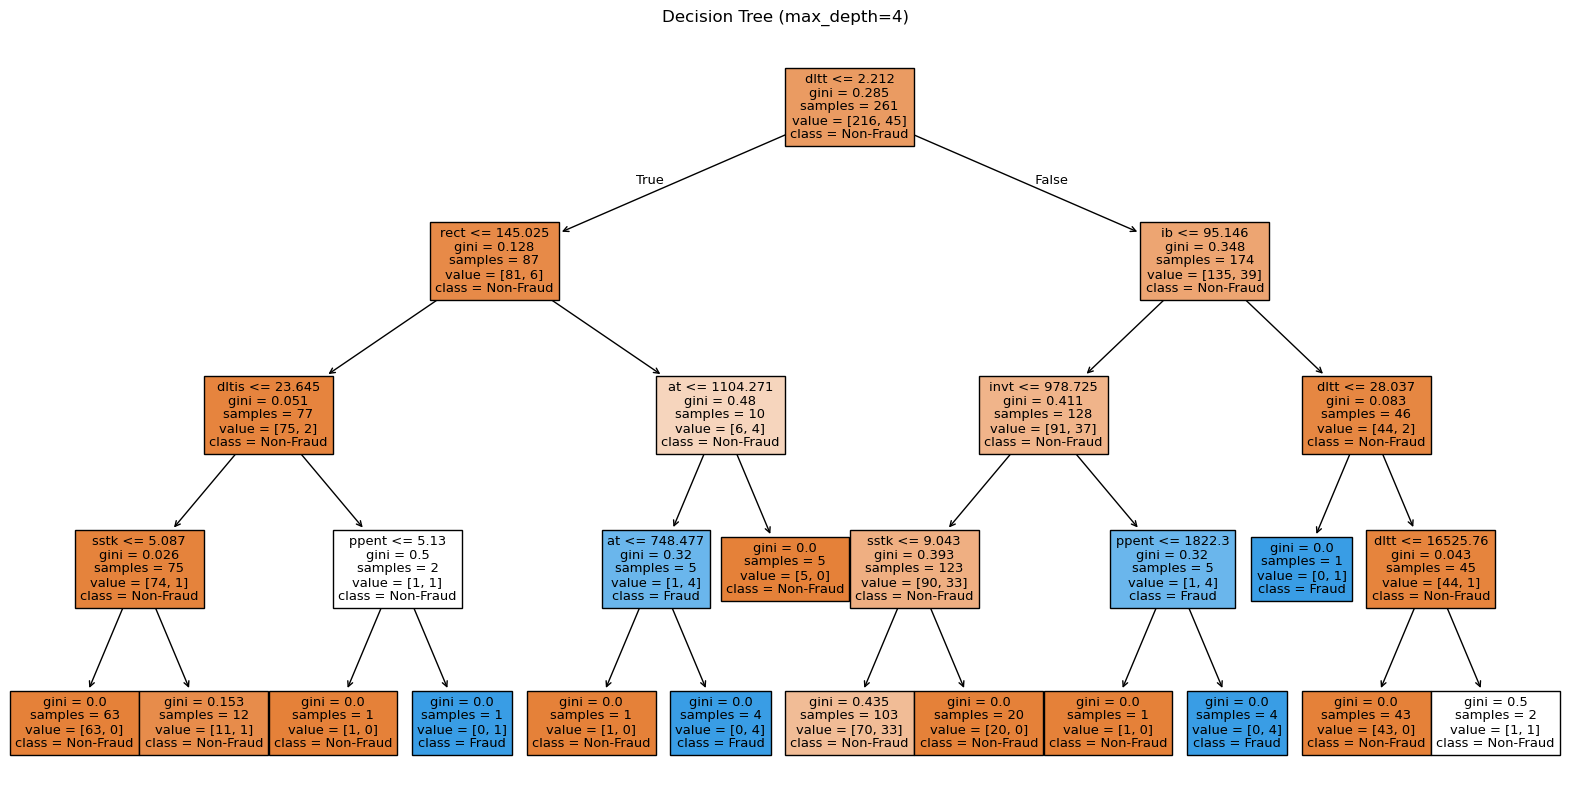

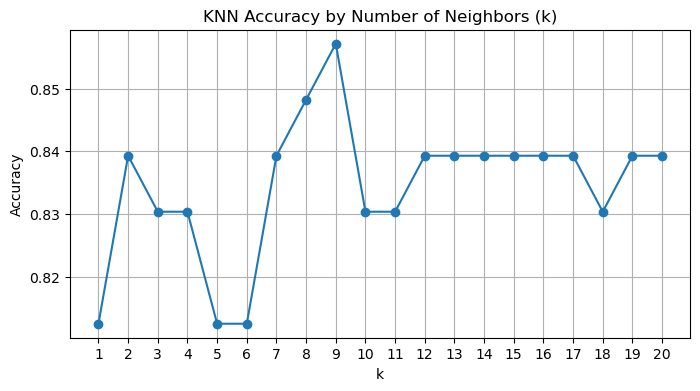

Best k for KNN: 9 with accuracy = 0.857


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

#Define predictors (same as logistic)
X = full_sample[dechow_vars]
y = full_sample["FRAUD"]

#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=213)

#Construct decision tree with different depths
depth_list = [2, 3, 4, 5, 6]
acc_tree = []

for depth in depth_list:
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=213)
    tree_model.fit(X_train, y_train)
    preds_tree = tree_model.predict(X_test)
    acc = accuracy_score(y_test, preds_tree)
    acc_tree.append(acc)
    print(f"Decision Tree (max_depth={depth}) accuracy: {acc:.3f}")

#Plot one tree
best_tree = DecisionTreeClassifier(max_depth=4, random_state=213)
best_tree.fit(X_train, y_train)
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X.columns, class_names=["Non-Fraud", "Fraud"], filled=True)
plt.title("Decision Tree (max_depth=4)")
plt.show()

#K-Nearest Neighbours: Try different k 
acc_knn = []
k_range = range(1, 21)

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    preds_knn = knn_model.predict(X_test)
    acc = accuracy_score(y_test, preds_knn)
    acc_knn.append(acc)

#Plot accuracy for K
plt.figure(figsize=(8, 4))
plt.plot(k_range, acc_knn, marker="o")
plt.title("KNN Accuracy by Number of Neighbors (k)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.xticks(k_range)
plt.grid(True)
plt.show()

#Final KNN model at best K
best_k = k_range[acc_knn.index(max(acc_knn))]
print(f"Best k for KNN: {best_k} with accuracy = {max(acc_knn):.3f}")

In this part, we use two machine learning methods, decision tree and K-nearest neighbors (KNN), to find accounting fraud by looking at financial statement data from Dechow et al. (2011). These variables include accruals, receivables, inventory changes, and other indicators of earnings manipulation.

The data was split into training and test sets (70/30), and models were evaluated based on their test accuracy. To ensure model comparability, only Dechow-style variables were used, and KNN inputs were standardized.

####  **1. Evaluate the predictive performance of the trees and find the best-performing tree**

We trained decision trees with different maximum depths (from 2 to 6). The test accuracy for each depth was recorded. The tree with:

- **max depth = 2** achieved the **highest test accuracy of 83.0%**

While deeper trees revealed more detailed splits, they tended to overfit. The best-performing tree was also the simplest.

This tree split on
- `fincf` (financing cash flow),
- `rect` (change in receivables),
- `at` (total assets),

These splits are consistent with prior research on red flags in fraudulent reporting.

The decision tree was preferred for its **transparency and interpretability**, allowing us to trace exactly how variables influence the classification of a firm as fraudulent.


####  **2. Evaluate the predictive performance and find the best set of variables and parameters (e.g. K) for KNN**

We tested KNN using the same Dechow-style variables, with `k` ranging from 1 to 20.

- The best result was at **k = 9**, achieving **test accuracy = 85.7%**

KNN's performance suggests that **local patterns** among similar firms may capture subtle signals of fraud that decision tree splits missed. However, KNN lacks interpretability, making it difficult to explain predictions in a regulatory or audit context.

Additionally, KNN was more sensitive to noise and class imbalance and required careful preprocessing (scaling).


####  Model Selection and Insight

While KNN gave the **highest accuracy**, it does not necessarily mean it detects fraud more effectively. Fraud is rare in the dataset, and high accuracy can occur even when few fraud cases are identified. The decision tree provided a clear structure that matched known fraud indicators from Dechow et al. (2011) and likely delivers better **fraud-specific insights**.


####  Conclusion

- The **best-performing tree** had max depth = 2, with 83.0% accuracy and interpretable splits based on key Dechow-style variables.
- The **best KNN model** used k = 9, achieving 85.7% accuracy, but lacked transparency and was harder to interpret.

Given the context of fraud detection, where explanation and auditability are critical, the decision tree is preferred, despite slightly lower accuracy.
